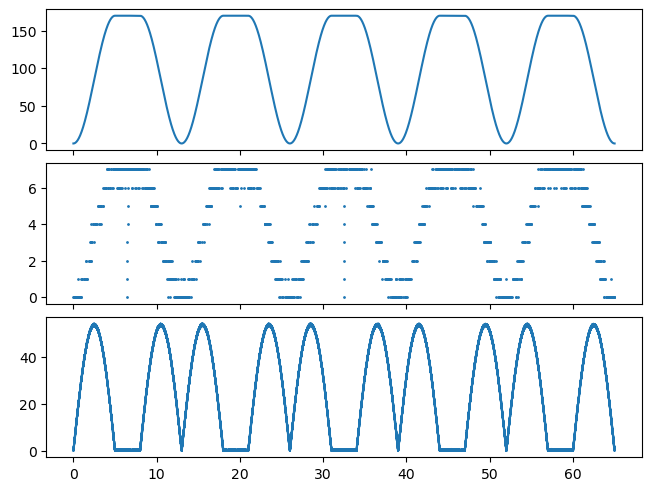

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)


In [11]:
from patsy import DesignInfo, DesignMatrix, build_design_matrices, dmatrix
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp

from sklearn import linear_model


def fit_regression(weights, spikes, position, df=5):
    data = {"x": position}

    design_matrix = dmatrix(f"bs(x, df={df})", data)

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)

    initial_condition = np.array([np.log(np.average(spikes, weights=weights))])
    initial_condition = np.concatenate(
        [initial_condition, np.zeros(design_matrix.shape[1] - 1)]
    )

    # res = minimize(
    #     neglogp, x0=initial_condition, method="Newton-CG", jac=dlike, hess=dlike2
    # )
    
    res = minimize(
        neglogp, x0=initial_condition, method="BFGS", jac=dlike
    )
    conditional_intensity = jnp.exp(design_matrix @ res.x)

    return conditional_intensity


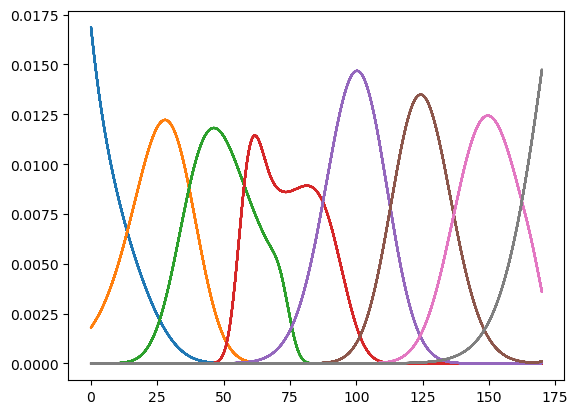

In [12]:
weights = np.ones_like(position)
rates = np.stack([fit_regression(weights, s, position) for s in spikes.T], axis=1)
plt.plot(position, rates)

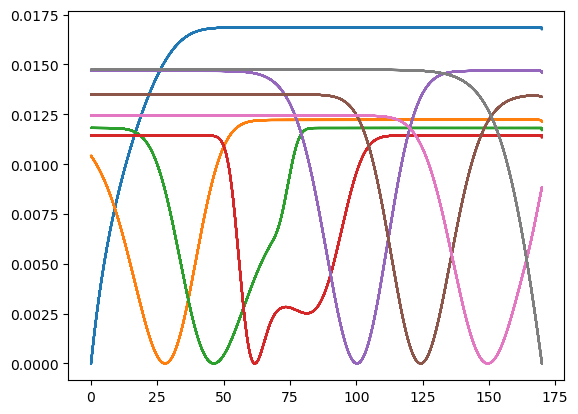

In [13]:
plt.plot(position, np.max(rates, axis=0, keepdims=True) - rates)

In [14]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
    poisson_log_likelihood,
)

tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.999, 0.001], [0.001, 0.999]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0


while not converged and (n_iter < max_iter):

    rates = np.stack(
        [fit_regression(is_training.astype(float), s, position) for s in spikes.T],
        axis=1,
    )

    likelihood = np.zeros((n_time, 2))
    likelihood[:, 0] = np.exp(np.sum(poisson_log_likelihood(spikes, rates), axis=1))
    likelihood[:, 1] = np.exp(
        np.sum(
            poisson_log_likelihood(
                spikes, np.max(rates, axis=0, keepdims=True) - rates
            ),
            axis=1,
        )
    )

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {data_log_likelihoods[-1]}")

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]


iteration 1, likelihood: -9448.81305424057
iteration 2, likelihood: -9333.524966000323, change: 115.28808824024782
iteration 3, likelihood: -9333.36330135402, change: 0.16166464630259725


(0.0, 50.0)

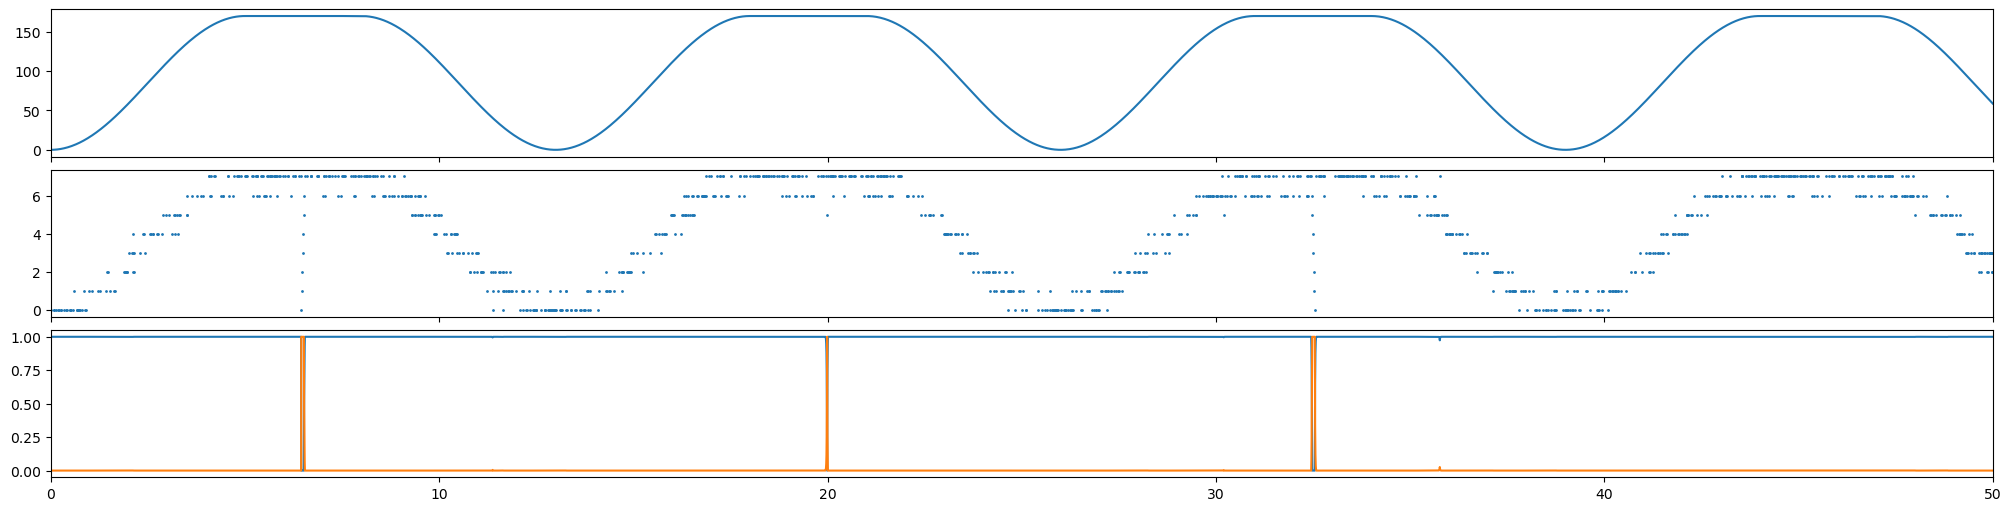

In [15]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 5))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, acausal_posterior)
plt.xlim((0, 50))


In [16]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
    poisson_log_likelihood,
)

spikes1 = spikes.copy()
spikes1[-20_000:-10_000] = 0.0

tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
n_iter = 0
converged = False

n_states = 3
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray(
    [[0.998, 0.001, 0.001],
     [0.001, 0.998, 0.001],
     [0.001, 0.001, 0.998]]
)
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0


while not converged and (n_iter < max_iter):

    rates = np.stack(
        [fit_regression(is_training.astype(float), s, position) for s in spikes1.T],
        axis=1,
    )
    zero_rates = np.ones_like(rates) * 1e-5 / sampling_frequency

    likelihood = np.zeros((n_time, n_states))
    likelihood[:, 0] = np.exp(np.sum(poisson_log_likelihood(spikes1, rates), axis=1))
    likelihood[:, 1] = np.exp(
        np.sum(
            poisson_log_likelihood(
                spikes, np.max(rates, axis=0, keepdims=True) - rates
            ),
            axis=1,
        )
    )
    likelihood[:, 2] = np.exp(
        np.sum(poisson_log_likelihood(spikes1, zero_rates), axis=1)
    )

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {data_log_likelihoods[-1]}")

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]


iteration 1, likelihood: -8688.824690054258
iteration 2, likelihood: -8492.56619483681, change: 196.2584952174475
iteration 3, likelihood: -8478.534473669242, change: 14.031721167568321
iteration 4, likelihood: -8473.545098639723, change: 4.989375029519579
iteration 5, likelihood: -8472.985018194368, change: 0.5600804453551973


(0.0, 64.99933333333334)

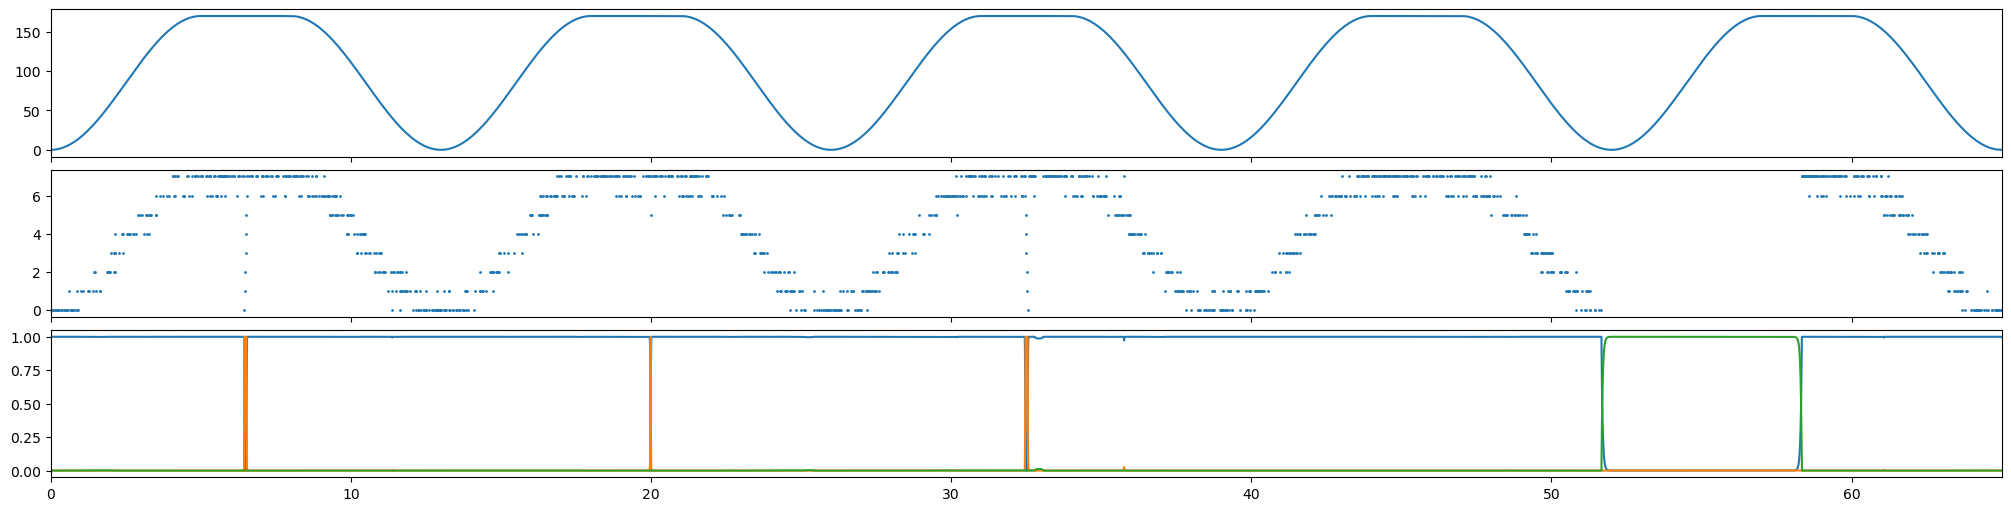

In [17]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 5))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes1)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, acausal_posterior)
plt.xlim((time.min(), time.max()))


In [13]:
import pandas as pd

position_info = pd.read_pickle("/Users/edeno/Downloads/Jaq_03_16_position_info.pkl")
spikes = pd.read_pickle("/Users/edeno/Downloads/Jaq_03_16_spikes.pkl")
is_ripple = pd.read_pickle("/Users/edeno/Downloads/Jaq_03_16_is_ripple.pkl")

spikes = np.asarray(spikes)
position = np.asarray(position_info.linear_position)


In [76]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
    poisson_log_likelihood,
)

spikes = np.asarray(spikes)
position = np.asarray(position_info.linear_position)

tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
n_iter = 0
converged = False

n_states = 3
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray(
    [[0.998, 0.001, 0.001], [0.001, 0.998, 0.001], [0.0001, 0.0001, 0.9998]]
)
is_training = ~np.asarray(is_ripple).copy()
zero_rates = np.ones_like(rates) * 1e-5 / sampling_frequency

while not converged and (n_iter < max_iter):

    rates = np.stack(
        [
            fit_regression(is_training.astype(float), s, position, df=7)
            for s in spikes.T
        ],
        axis=1,
    )

    likelihood = np.zeros((n_time, n_states))
    likelihood[:, 0] = np.exp(np.sum(poisson_log_likelihood(spikes, rates), axis=1))
    likelihood[:, 1] = np.exp(
        np.sum(
            poisson_log_likelihood(
                spikes, np.max(rates, axis=0, keepdims=True) - rates
            ),
            axis=1,
        )
    )
    likelihood[:, 2] = np.exp(
        np.sum(poisson_log_likelihood(spikes, zero_rates), axis=1)
    )

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {data_log_likelihoods[-1]}")

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]


iteration 1, likelihood: -1969490.9705134144
iteration 2, likelihood: -1954204.0907084735, change: 15286.879804940894
iteration 3, likelihood: -1950672.8739276323, change: 3531.2167808411177
iteration 4, likelihood: -1948886.638753368, change: 1786.2351742642932
iteration 5, likelihood: -1947735.0517367888, change: 1151.5870165792294
iteration 6, likelihood: -1947021.5702920856, change: 713.4814447031822
iteration 7, likelihood: -1946600.237746362, change: 421.33254572353326
iteration 8, likelihood: -1946350.3988040914, change: 249.83894227072597
iteration 9, likelihood: -1946151.0534499658, change: 199.34535412560217
iteration 10, likelihood: -1946076.1254269653, change: 74.92802300048061


(22499.082875307, 22504.082875307)

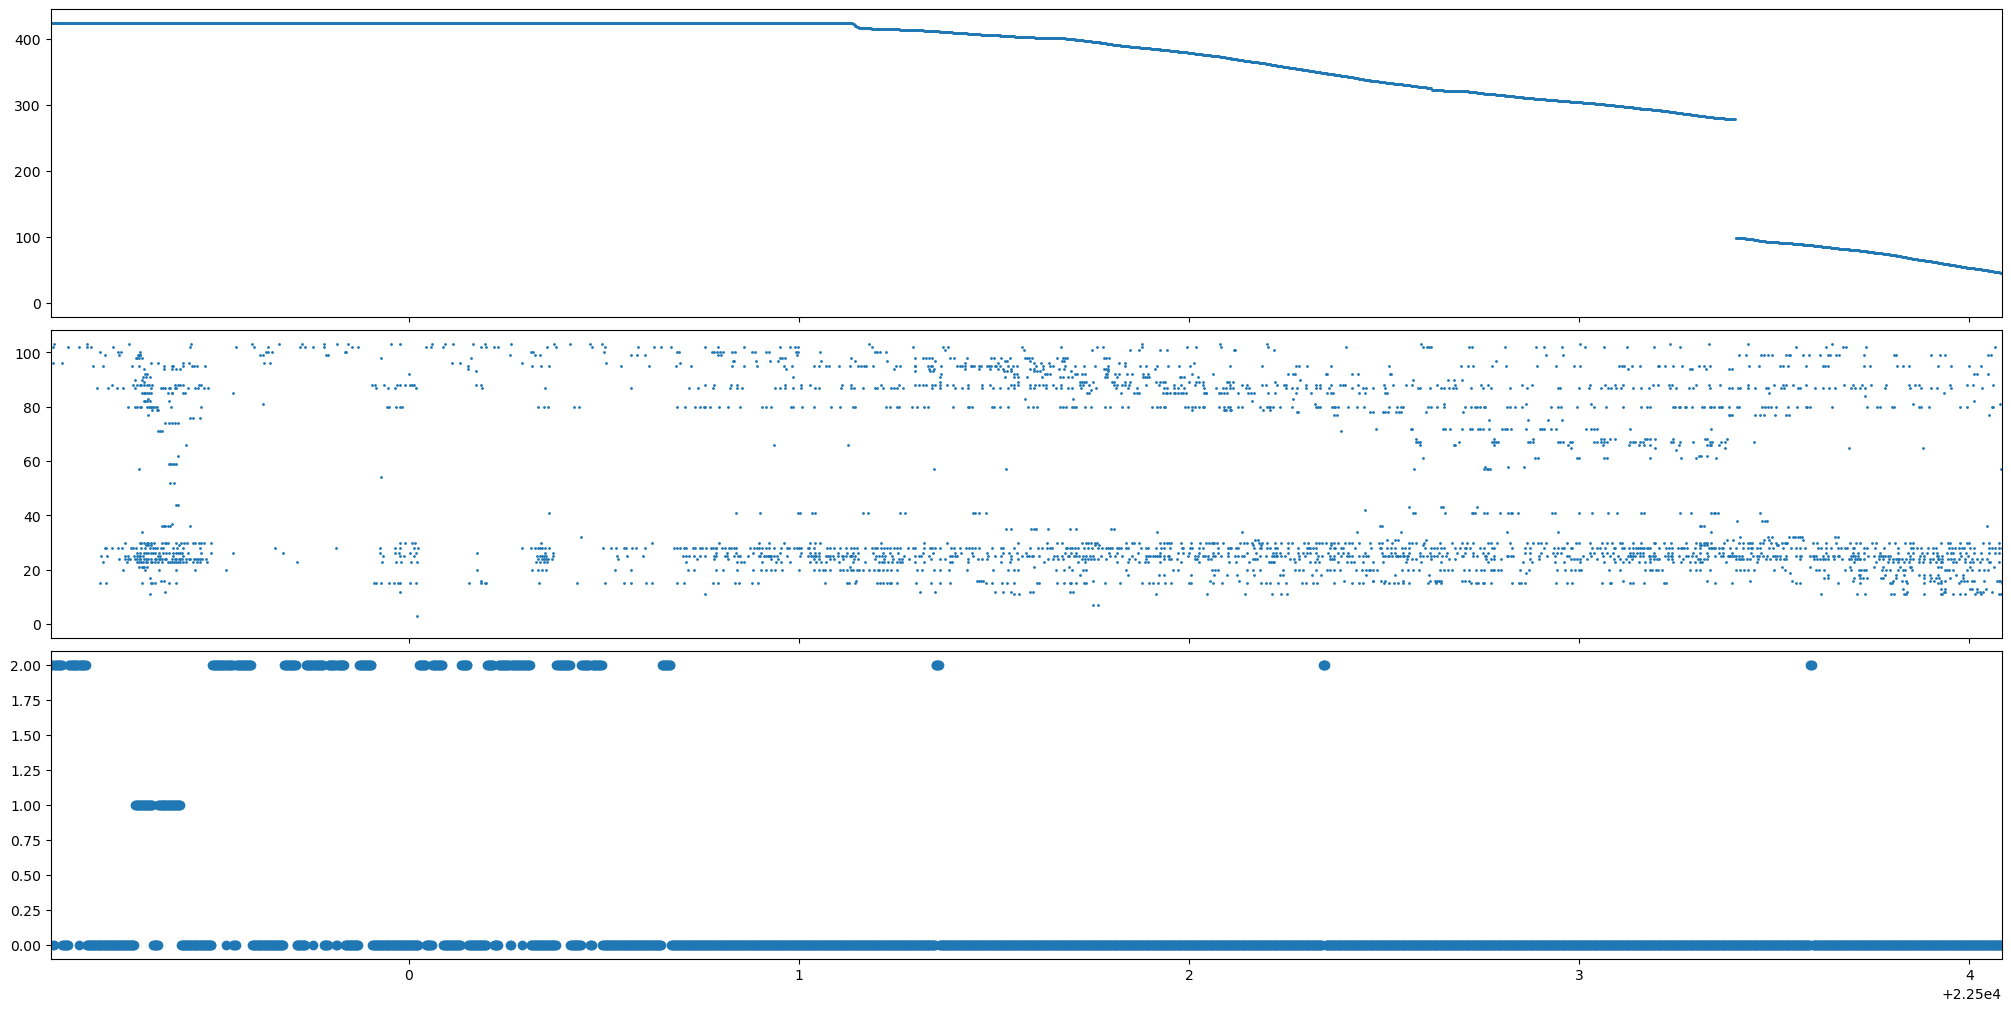

In [114]:
time = position_info.index / np.timedelta64(1, "s")
neuron_sort_ind = np.argsort(position[rates.argmax(axis=0)])

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].scatter(time, position, s=1)
spike_time_ind, neuron_ind = np.nonzero(spikes[:, neuron_sort_ind])
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].scatter(time, predicted_state)
plt.xlim((time.min() + 110, time.min() + 115))


In [109]:
transition_matrix[2, 2]


0.7942186845680551